# Preliminaries

This commands are used in Google Colab:

!pip install deap

from google.colab import drive
drive.mount("/content/gdrive")

Importing python packages and setting display parameters

In [1]:
import math as mt
import random as rnd
import numpy as np
import itertools as it

import numba
from numba import jit
import joblib

import matplotlib as mpl
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import EngFormatter

import pandas as pd
import statistics as stats

In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = "retina"

plt.style.use("default")
plt.style.use("bmh")
# plt.rcParams.update({"figure.autolayout": True})
plt.rcParams["figure.figsize"] = (12, 9)
mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.dpi"] = 100

In [3]:
pd.set_option("display.latex.repr", True)

In [24]:
pd.set_option("display.latex.longtable", True)

This sets the work directory for the pickle files

In [4]:
pickle_dir = "./pickle/"
file_sufix = "C_02"
pickle_dir + file_sufix

'./pickle/C_02'

Run this when working in Google Colab:

pickle_dir = "/content/gdrive/My Drive/Colab Notebooks/thesis/"
pickle_dir + file_sufix

# Experiment parameters

## Common parameters

In [5]:
# Algorithm parameters
# Number of replicates, and generations per experiment
rep_end = 40
births_end = 120e3

# Genes
gen_size = 2
# Population size
pop_size_lvl = [20, 10, 40, 80, 160]
# Progeny and parents size ratio to population size
b_ratio_lvl = [3, 0.6, 1, 2, 5]

# Progeny parameters
## Crossover probability per gene
cx_pb_lvl = [0.5, 0.1, 0.25, 0.75, 0.9]
## Mutation probability per gene
mut_pb_lvl = [0.5, 0.1, 0.25, 0.75, 0.9]
## Mutation strength
mut_sig_lvl = [2.5, 0.5, 1.25, 5, 7.5, 10]

# Selection by tournament
# Tournament size parent selection
k_par_lvl = [2, 1, 4, 6, 7]
# Tournament size survivor selection
k_sur_lvl = [6, 1, 3, 4, 7]

### Factor levels

In [6]:
factors_levels = [
    ("pop", "Population size", "Integer +", pop_size_lvl, pop_size_lvl[0]),
    ("b_ratio", "Progeny-to-pop ratio", "Real +", b_ratio_lvl, b_ratio_lvl[0]),
    ("cx_pb", "Crossover prob", "Real [0,1]", cx_pb_lvl, cx_pb_lvl[0]),
    ("mut_pb", "Mutation prob", "Real [0,1]", mut_pb_lvl, mut_pb_lvl[0]),
    ("mut_sig", "Mutation sigma", "Real +", mut_sig_lvl, mut_sig_lvl[0]),
    ("k_par", "Parent tourn size", "Integer +", k_par_lvl, k_par_lvl[0]),
    ("k_sur", "Surviv tourn size", "Integer +", k_sur_lvl, k_sur_lvl[0]),
]

factors_df = pd.DataFrame(
    factors_levels, columns=["Factor", "Label", "Range", "Levels", "Default"]
)
factors_df = factors_df.set_index(["Factor"])

factors_df

,Label,Range,Levels,Default
Factor,,,,
pop,Population size,Integer +,"[20, 10, 40, 80, 160]",20.0
b_ratio,Progeny-to-pop ratio,Real +,"[3, 0.6, 1, 2, 5]",3.0
cx_pb,Crossover prob,"Real [0,1]","[0.5, 0.1, 0.25, 0.75, 0.9]",0.5
mut_pb,Mutation prob,"Real [0,1]","[0.5, 0.1, 0.25, 0.75, 0.9]",0.5
mut_sig,Mutation sigma,Real +,"[2.5, 0.5, 1.25, 5, 7.5, 10]",2.5
k_par,Parent tourn size,Integer +,"[2, 1, 4, 6, 7]",2.0
k_sur,Surviv tourn size,Integer +,"[6, 1, 3, 4, 7]",6.0


# Data Analysis

Reading the dataframes of the values to plot and the final results from the files

In [8]:
fit_df_file = pickle_dir + file_sufix + "_fit_df.xz"
fit_fin_df_file = pickle_dir + file_sufix + "_fit_fin_df.xz"
fit_30k_df_file = pickle_dir + file_sufix + "_fit_30k_df.xz"
fit_60k_df_file = pickle_dir + file_sufix + "_fit_60k_df.xz"

In [9]:
%time
fit_plot = pd.read_pickle(fit_df_file)

fit_30k = pd.read_pickle(fit_30k_df_file)
fit_60k = pd.read_pickle(fit_60k_df_file)
fit_120k = pd.read_pickle(fit_fin_df_file)

query_exact = fit_30k["best"] < 1e-6
fit_30k_exact = fit_30k[query_exact]
query_exact = fit_60k["best"] < 1e-6
fit_60k_exact = fit_60k[query_exact]
query_exact = fit_120k["best"] < 1e-6
fit_120k_exact = fit_120k[query_exact]

Wall time: 0 ns


In [10]:
print(len(fit_plot))
print(len(fit_30k) / 40)
print(len(fit_60k) / 40)
print(len(fit_120k) / 40)

582440
36.0
36.0
36.0


In [11]:
fit_30k = fit_30k[['exp', 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur',
       'rep', 'births','best']]
fit_30k['births'] = 30000
fit_30k.head().append(fit_30k.tail())

,exp,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,rep,births,best
0,1,10,3.0,0.5,0.5,2.5,2,6,1,30000,5.113027e+00
1,1,10,3.0,0.5,0.5,2.5,2,6,2,30000,5.465632e-05
2,1,10,3.0,0.5,0.5,2.5,2,6,3,30000,6.084925e+00
3,1,10,3.0,0.5,0.5,2.5,2,6,4,30000,2.125114e-05
4,1,10,3.0,0.5,0.5,2.5,2,6,5,30000,5.113132e+00
1435,7,20,3.0,0.5,0.5,2.5,2,7,36,30000,6.804050e-05
1436,7,20,3.0,0.5,0.5,2.5,2,7,37,30000,6.084948e+00
1437,7,20,3.0,0.5,0.5,2.5,2,7,38,30000,5.113032e+00
1438,7,20,3.0,0.5,0.5,2.5,2,7,39,30000,8.191609e-07
1439,7,20,3.0,0.5,0.5,2.5,2,7,40,30000,1.616776e-06


In [12]:
fit_60k = fit_60k[['exp', 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur',
       'rep', 'births','best']].reset_index(drop=True)
fit_60k['births'] = 60000
fit_60k.head().append(fit_60k.tail())

,exp,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,rep,births,best
0,1,10,3.0,0.5,0.5,2.5,2,6,1,60000,5.113027e+00
1,1,10,3.0,0.5,0.5,2.5,2,6,2,60000,1.807508e-06
2,1,10,3.0,0.5,0.5,2.5,2,6,3,60000,6.084909e+00
3,1,10,3.0,0.5,0.5,2.5,2,6,4,60000,1.076612e-05
4,1,10,3.0,0.5,0.5,2.5,2,6,5,60000,5.113029e+00
1435,7,20,3.0,0.5,0.5,2.5,2,7,36,60000,2.070812e-06
1436,7,20,3.0,0.5,0.5,2.5,2,7,37,60000,6.084921e+00
1437,7,20,3.0,0.5,0.5,2.5,2,7,38,60000,5.113032e+00
1438,7,20,3.0,0.5,0.5,2.5,2,7,39,60000,3.371651e-07
1439,7,20,3.0,0.5,0.5,2.5,2,7,40,60000,1.616776e-06


In [13]:
fit_120k = fit_120k[['exp', 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur',
       'rep', 'births','best']].reset_index(drop=True)
fit_120k['births'] = 120000
fit_120k = fit_120k
fit_120k.head().append(fit_120k.tail())

,exp,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,rep,births,best
0,1,20,3.0,0.5,0.5,2.5,2,6,1,120000,1.511744e-07
1,1,20,3.0,0.5,0.5,2.5,2,6,2,120000,4.820148e-07
2,1,20,3.0,0.5,0.5,2.5,2,6,3,120000,4.724888e-07
3,1,20,3.0,0.5,0.5,2.5,2,6,4,120000,6.084911e+00
4,1,20,3.0,0.5,0.5,2.5,2,6,5,120000,6.306626e-07
1435,7,20,3.0,0.5,0.5,2.5,2,7,36,120000,2.070812e-06
1436,7,20,3.0,0.5,0.5,2.5,2,7,37,120000,6.084912e+00
1437,7,20,3.0,0.5,0.5,2.5,2,7,38,120000,5.113032e+00
1438,7,20,3.0,0.5,0.5,2.5,2,7,39,120000,5.622309e-08
1439,7,20,3.0,0.5,0.5,2.5,2,7,40,120000,1.458054e-07


In [14]:
fit_results = fit_30k.copy()
fit_results = fit_results.append(fit_60k, sort=False)
fit_results = fit_results.append(fit_120k, sort=False)
fit_results = fit_results.reset_index(drop=True)

In [15]:
fit_results.head()

,exp,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,rep,births,best
0,1,10,3.0,0.5,0.5,2.5,2,6,1,30000,5.113027
1,1,10,3.0,0.5,0.5,2.5,2,6,2,30000,0.000055
2,1,10,3.0,0.5,0.5,2.5,2,6,3,30000,6.084925
3,1,10,3.0,0.5,0.5,2.5,2,6,4,30000,0.000021
4,1,10,3.0,0.5,0.5,2.5,2,6,5,30000,5.113132


In [18]:
x_y_z = fit_120k.groupby(['exp', 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur'])[["best"]].size()
x_y_z = x_y_z.reset_index()
x_y_z["Par Conf"] = x_y_z.index
#x_y_z.index.names=["Par Conf"]
x_y_z = x_y_z.rename(columns={0:"Replicates"})
x_y_z = x_y_z[['exp', 'Par Conf', 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur',
       'Replicates']]
x_y_z

,exp,Par Conf,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,Replicates
0,1,0,10,3.0,0.50,0.50,2.50,2,6,40
1,1,1,20,3.0,0.50,0.50,2.50,2,6,40
2,1,2,40,3.0,0.50,0.50,2.50,2,6,40
3,1,3,80,3.0,0.50,0.50,2.50,2,6,40
4,1,4,160,3.0,0.50,0.50,2.50,2,6,40
5,2,5,20,0.6,0.50,0.50,2.50,2,6,40
6,2,6,20,1.0,0.50,0.50,2.50,2,6,40
7,2,7,20,2.0,0.50,0.50,2.50,2,6,40
8,2,8,20,3.0,0.50,0.50,2.50,2,6,40
9,2,9,20,5.0,0.50,0.50,2.50,2,6,40


In [20]:
bins = [-1e-8, 1e-6, 1, 5, 6, 7, float("inf")]

In [21]:
a_b_c = fit_results.copy()
a_b_c["bins"] = pd.cut(a_b_c["best"], bins)
a_b_c = a_b_c.merge(x_y_z[["exp", 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur', 'Par Conf']], 
                    on=["exp", 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur'])
a_b_c = a_b_c[["exp", "Par Conf", "rep", "births", "bins"]]
a_b_c = a_b_c.groupby(['exp','Par Conf', 'bins', "births"]).size().unstack(level=-1, fill_value=0)
a_b_c = a_b_c.reset_index()
a_b_c.sort_values(by=[120000], ascending=False)

births,exp,Par Conf,bins,30000,60000,120000
100,5,25,"(1e-06, 1.0]",38,39,35
97,5,24,"(1e-06, 1.0]",38,37,34
16,1,4,"(-1e-08, 1e-06]",4,18,28
84,5,21,"(-1e-08, 1e-06]",6,19,26
12,1,3,"(-1e-08, 1e-06]",3,6,26
79,5,20,"(-1e-08, 1e-06]",22,24,24
0,1,0,"(-1e-08, 1e-06]",0,5,23
76,4,19,"(1e-06, 1.0]",24,24,23
43,3,11,"(-1e-08, 1e-06]",3,9,22
93,5,23,"(1e-06, 1.0]",25,25,22


In [22]:
d_e_f = fit_results.copy()
d_e_f["bins"] = pd.cut(d_e_f["best"], bins)
d_e_f = d_e_f.merge(x_y_z[["exp", 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur', 'Par Conf']], 
                    on=["exp", 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur'])
d_e_f = d_e_f[["exp", "Par Conf", "rep", "births", "bins"]]
d_e_f = d_e_f.groupby(['exp','Par Conf', "births", 'bins']).size().unstack(level=-1, fill_value=0)
d_e_f

bins                 (-1e-08, 1e-06]  (1e-06, 1.0]  (1.0, 5.0]  (5.0, 6.0]  \
exp Par Conf births                                                          
1   0        30000                 0            29           0           5   
             60000                 5            24           0           5   
             120000               23             6           0           5   
    1        30000                 3            23           0           8   
             60000                 9            17           0           8   
             120000               21             5           0           8   
    2        30000                 0            26           0          13   
             60000                 4            22           0          13   
             120000               19             7           0          13   
    3        30000                 3            33           0           1   
             60000                 6            30           0  

In [35]:
kkk = fit_results.copy()
query = kkk["best"] < 1e-6
kkk = kkk[query]
kkk["best"].min()

-8.537881512893364e-11

In [31]:
t_u_v = fit_results.copy()
t_u_v = t_u_v.merge(x_y_z[["exp", 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur', 'Par Conf']], 
                    on=["exp", 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur'])
t_u_v = t_u_v[['exp', 'Par Conf', 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur',
       'rep', 'births', 'best']]
t_u_v = t_u_v.assign(Successful= lambda x:x["best"]<1e-6)
t_u_v = t_u_v.groupby(["exp", "Par Conf", 'pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur', "births"])
t_u_v = t_u_v["Successful"].sum().reset_index()
t_u_v["Successful"] = t_u_v["Successful"]/40*100
t_u_v

,exp,Par Conf,pop,b_ratio,cx_pb,mut_pb,mut_sig,k_par,k_sur,births,Successful
0,1,0,10,3.0,0.5,0.5,2.5,2,6,30000,0.0
1,1,0,10,3.0,0.5,0.5,2.5,2,6,60000,12.5
2,1,0,10,3.0,0.5,0.5,2.5,2,6,120000,57.5
3,1,1,20,3.0,0.5,0.5,2.5,2,6,30000,7.5
4,1,1,20,3.0,0.5,0.5,2.5,2,6,60000,22.5
5,1,1,20,3.0,0.5,0.5,2.5,2,6,120000,52.5
6,1,2,40,3.0,0.5,0.5,2.5,2,6,30000,0.0
7,1,2,40,3.0,0.5,0.5,2.5,2,6,60000,10.0
8,1,2,40,3.0,0.5,0.5,2.5,2,6,120000,47.5
9,1,3,80,3.0,0.5,0.5,2.5,2,6,30000,7.5


# Visualization

Factors to iterate in the visualization

In [36]:
factors = list(factors_df.index.array)
print(factors)
fact = list(fit_plot.columns)
fact = fact[1:8]

['pop', 'b_ratio', 'cx_pb', 'mut_pb', 'mut_sig', 'k_par', 'k_sur']


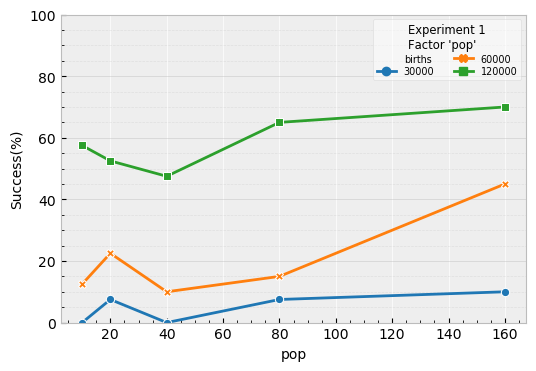

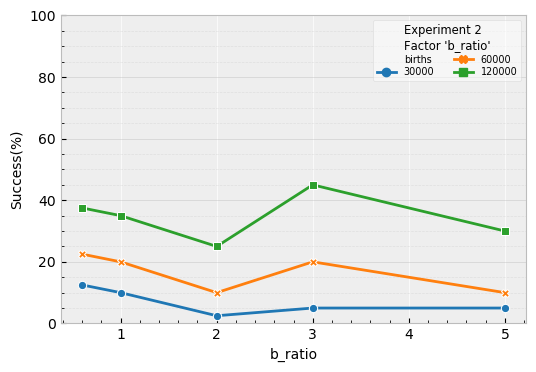

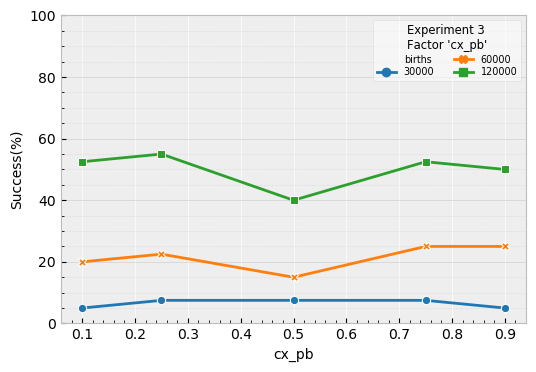

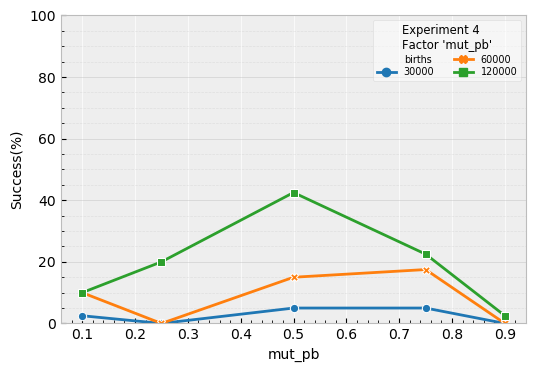

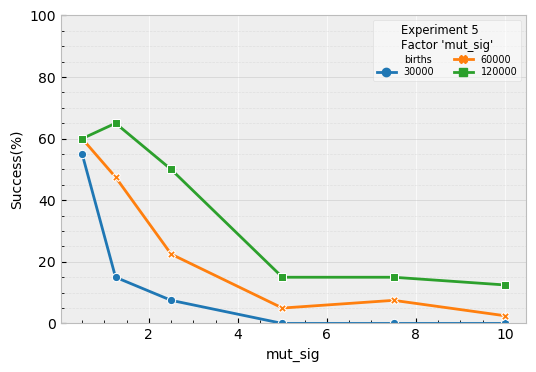

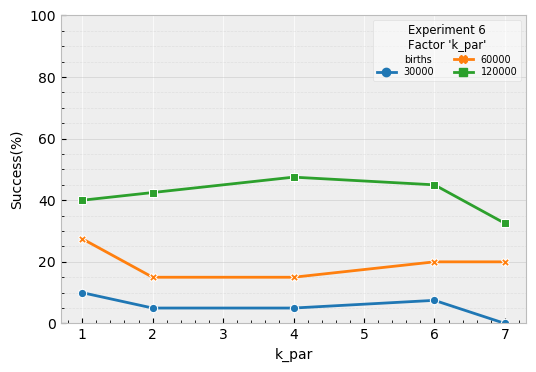

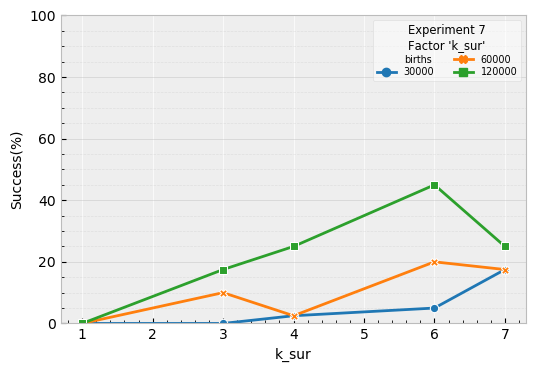

In [38]:
for i in range(1,8):
    query= t_u_v["exp"] == i
    plot_data = t_u_v[query]
    fig, ax = plt.subplots(figsize=(6,4))

    palette = sns.color_palette("tab10", 3)
    sns.lineplot(x=factors[i-1], y="Successful", hue="births", style="births", markers=True, dashes=False, palette=palette, data=plot_data, ax=ax)
    #ax.legend(labelspacing=0.25, fontsize="x-small", ncol=2,           title="Experiment "+ str(exp_n + 1) + "\nFactor '" + exp_factor + "'",            title_fontsize="small", facecolor="white",framealpha=0.5,loc=1,)
    ax.legend(labelspacing=0.25, ncol=2, facecolor="white", framealpha=0.5, fontsize="x-small",  
              title="Experiment "+ str(i) + "\nFactor '" + factors[i-1] + "'", title_fontsize="small", 
              )
    ax.set_ylim(0, 100)
    ax.set_xlabel(factors[i-1], fontsize="medium")
    ax.set_ylabel("Success(%)", fontsize="medium")

    ax.set_axisbelow(True)
    ax.minorticks_on()
    ax.grid(True, axis="x", which="major", alpha=1, color="w", ls="-")
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.grid(True, axis="y", which="major", alpha=0.5, ls="-")
    ax.grid(True, axis="y", which="minor", alpha=0.25, ls="--")

In [40]:
formatter1 = EngFormatter(places=0, sep=u"\N{THIN SPACE}")  # U+2009

## Histograms

In [41]:
list_df = [
    "fit_30k",
    "fit_60k",
    "fit_120k",
    "fit_30k_exact",
    "fit_60k_exact",
    "fit_120k_exact",
]
list_texts = [
    "(a) at 30 K",
    "(b) at 60 K",
    "(c) at 120 K",
    "(d) at 30 K",
    "(e) at 60 K",
    "(f) at 120 K",
]

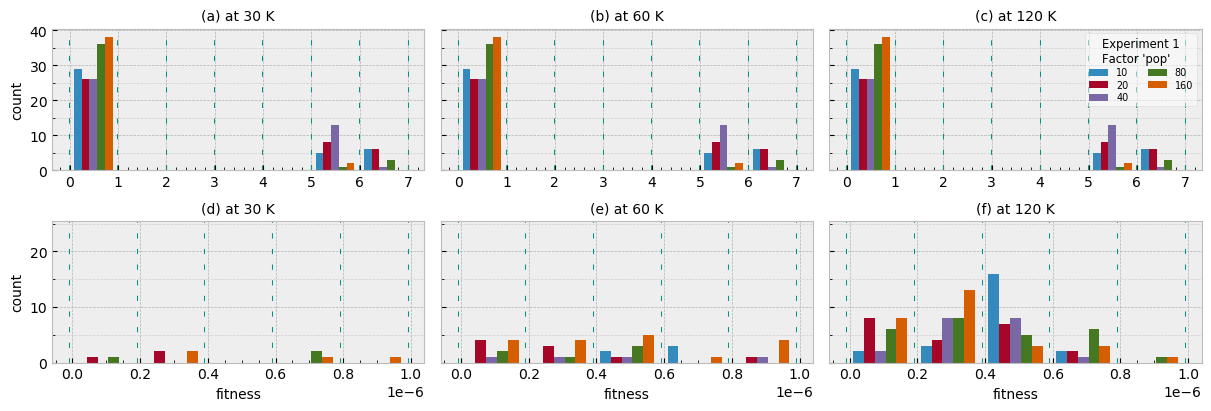

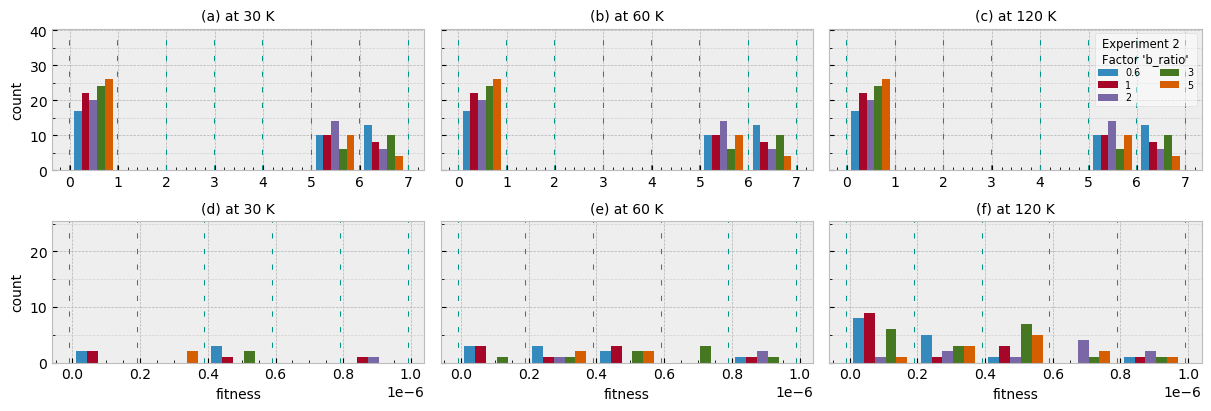

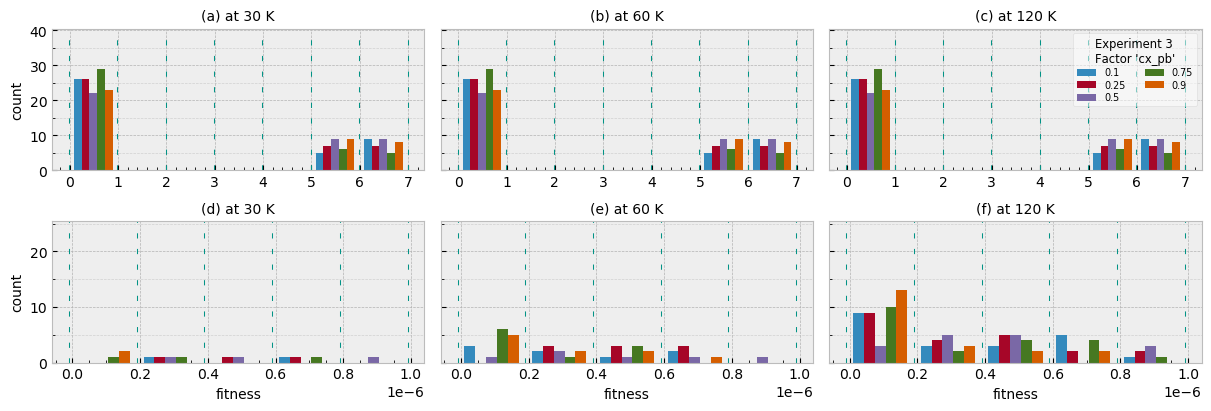

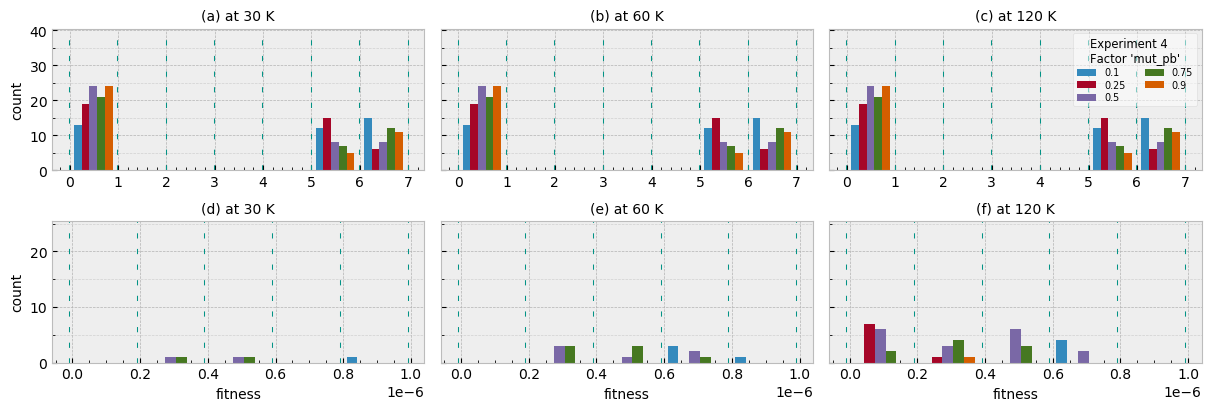

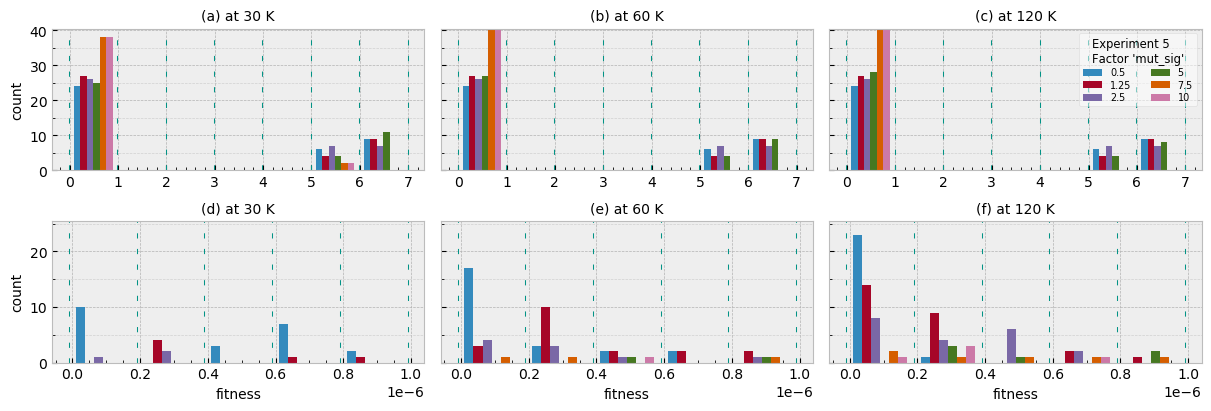

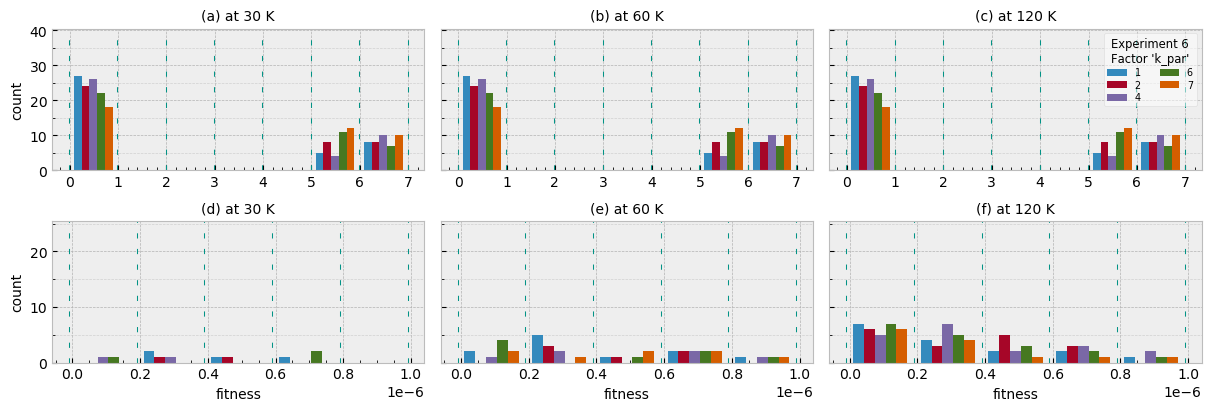

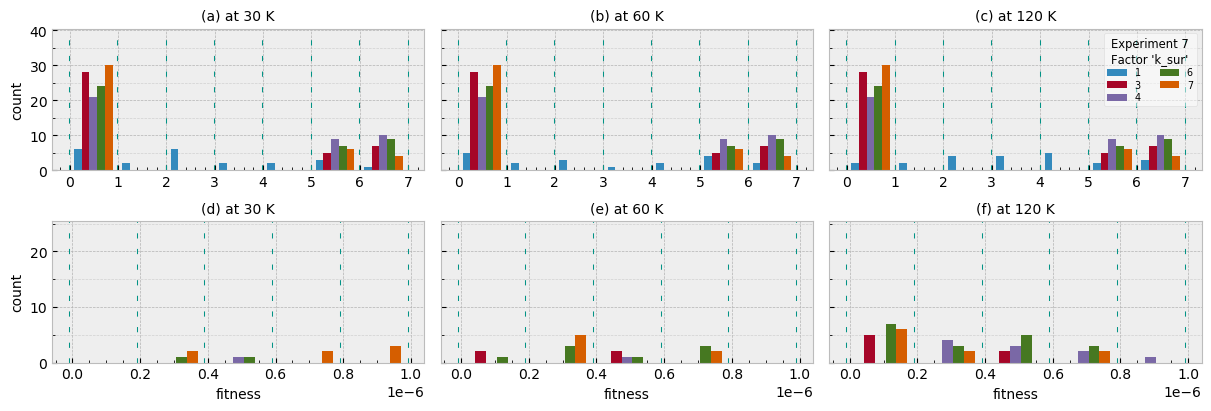

Wall time: 30.9 s


In [15]:
%%time
for exp_n in range(7):
    fig, axs = plt.subplots(
        nrows=2,
        ncols=3,
        sharey="row",
        sharex="row",
        constrained_layout=True,
        figsize=(12, 4),
    )

    for i, ax in enumerate(axs.flat):
        query1 = eval(list_df[i])["exp"] == (exp_n + 1)
        exp_data = eval(list_df[i])[query1]
        exp_factor = factors[exp_n]
        exp_levels = factors_df["Levels"][exp_n]
        exp_levels.sort()

        hist_label = []
        hist_data = []
        for k in range(len(exp_levels)):
            query2 = exp_data[exp_factor] == exp_levels[k]
            hist_data.append(exp_data[query2]["best"].tolist())
            hist_label.append(exp_levels[k])

        if i <= 2:
            bins = np.linspace(-0.01, 6.99, 7 + 1)
        else:
            bins = np.linspace(-1e-8, 1e-6 - 1e-8, num=6)
        ax.hist(hist_data, bins, label=hist_label)
        ax.vlines(
            bins, 0, 40, colors="xkcd:teal", linestyles=(0, (5, 10)), linewidths=0.75
        )
        ax.set_title(list_texts[i], fontsize="medium")
        ax.set_axisbelow(True)
        ax.minorticks_on()
        ax.set_yticks([5, 15, 25, 35], minor=True)
        ax.grid(True, axis="y", which="minor", alpha=0.5)

    for i, row in enumerate(axs):
        for j, cell in enumerate(row):
            if i == 0:
                cell.set_ylim(None, 40.5)
                if j == 2:
                    cell.legend(
                        labelspacing=0.25,
                        fontsize="x-small",
                        ncol=2,
                        title="Experiment "
                        + str(exp_n + 1)
                        + "\nFactor '"
                        + exp_factor
                        + "'",
                        title_fontsize="small",
                        facecolor="white",
                        framealpha=0.5,
                        loc=1,
                    )
            if i == 1:
                cell.set_ylim(None, 25.5)
                cell.ticklabel_format(style="sci", axis="x", scilimits=(0, 0))
            if i == len(axs) - 1:
                cell.set_xlabel("fitness", fontsize="medium")
            if j == 0:
                cell.set_ylabel("count", fontsize="medium")

    # fig.suptitle("Histograms of replicate's best fitness per experiment factor's levels at different birth counts", fontsize='large')
    plt.show()

## Average fitness development

### Agregated per experiment and level

Development of minimum (best) fitness for each level of each experiment

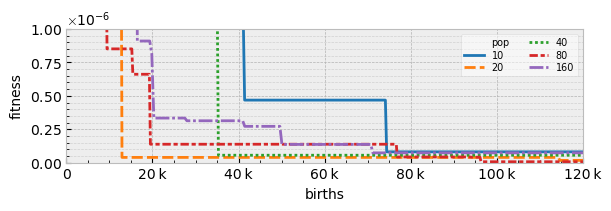

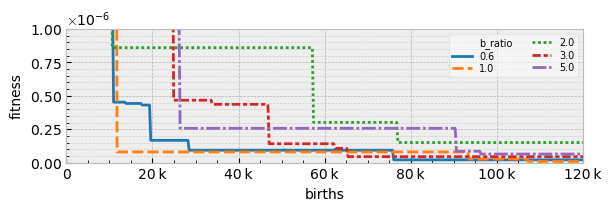

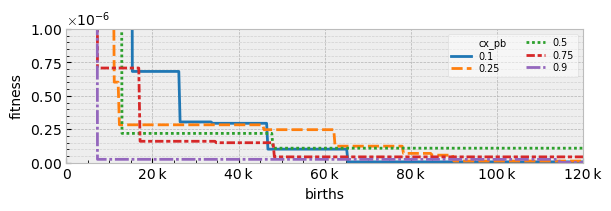

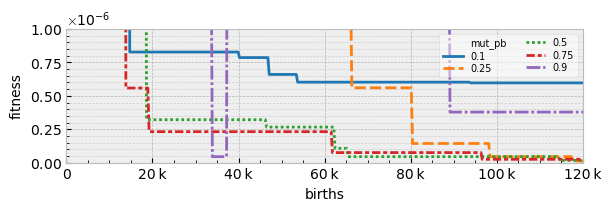

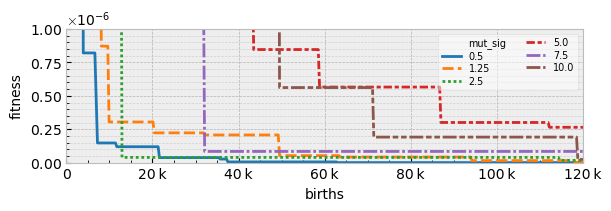

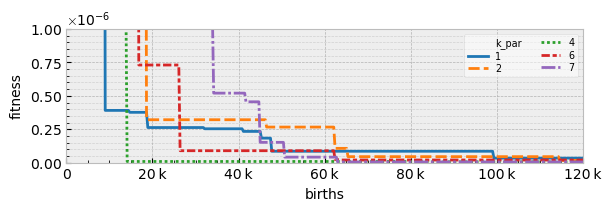

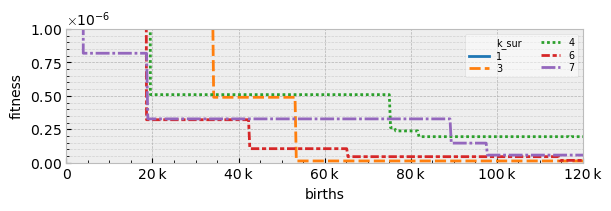

Wall time: 13.3 s


In [78]:
%%time
for exp_n in range(7):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 2))
    if exp_n in [4]:
        palette = sns.color_palette("tab10", 6)
    else:
        palette = sns.color_palette("tab10", 5)
    query = fit_plot["exp"] == (exp_n + 1)
    data_exp = fit_plot[query]
    sns.lineplot(
        x="births",
        y="best",
        style=factors[exp_n],
        hue=factors[exp_n],
        palette=palette,
        data=data_exp,
        ci=None,
        ax=ax,
        estimator=np.min,
    )
    ax.set_axisbelow(True)
    ax.legend(
        labelspacing=0.25,
        fontsize="x-small",
        ncol=2,
#        title="Experiment " + str(exp_n + 1),
#        title_fontsize="small",
        facecolor="white",
        framealpha=0.5,
        loc=0,
    )
    ax.xaxis.set_major_formatter(formatter1)
    ax.set_xlim((0, 120e3))
    ax.set_xlabel("births", fontsize="medium")
    ax.set_ylim((0, .000001))
    ax.set_ylabel("fitness", fontsize="medium")
    ax.minorticks_on()
#    ax.set_yticks([1, 3, 5], minor=True)
    ax.grid(True, axis="y", which="minor", alpha=0.5)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0), useMathText=True)
    
    plt.show()

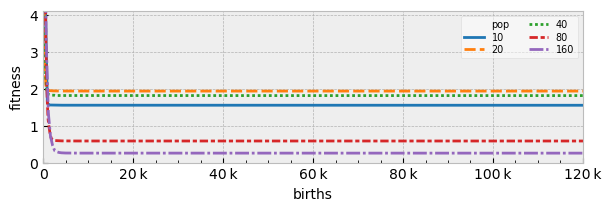

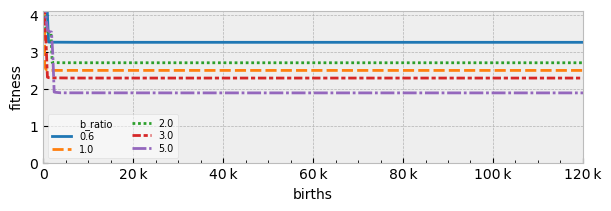

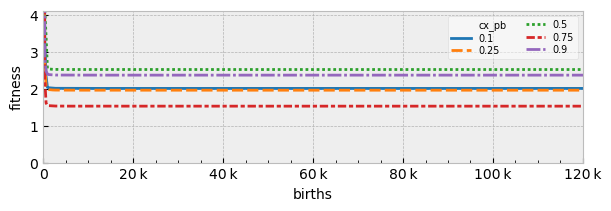

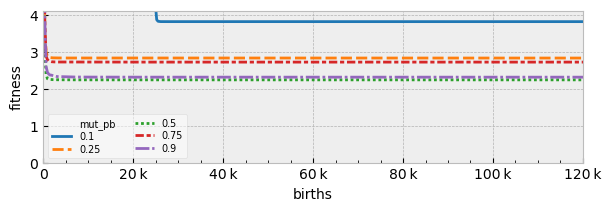

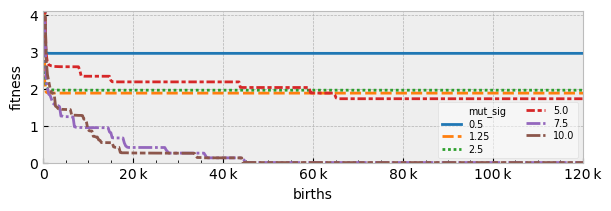

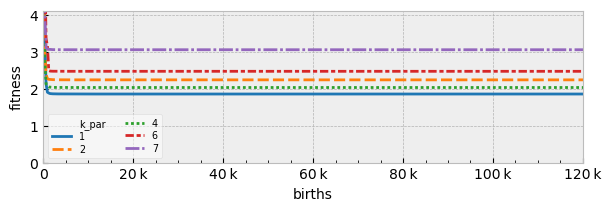

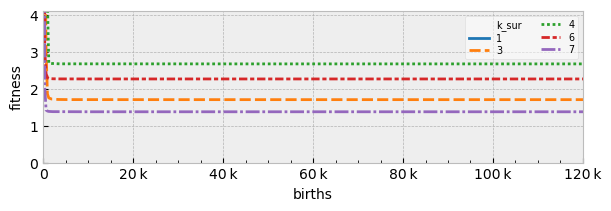

Wall time: 9.06 s


In [69]:
%%time
for exp_n in range(7):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 2))
    if exp_n in [4]:
        palette = sns.color_palette("tab10", 6)
    else:
        palette = sns.color_palette("tab10", 5)
    query = fit_plot["exp"] == (exp_n + 1)
    data_exp = fit_plot[query]
    sns.lineplot(
        x="births",
        y="best",
        style=factors[exp_n],
        hue=factors[exp_n],
        palette=palette,
        data=data_exp,
        ci=None,
        #        ci=68,
        ax=ax,
        estimator=np.mean,
    )
    ax.set_axisbelow(True)
    ax.legend(
        labelspacing=0.25,
        fontsize="x-small",
        ncol=2,
#        title="Experiment " + str(exp_n + 1),
#        title_fontsize="small",
        facecolor="white",
        framealpha=0.5,
        loc=0,
    )
    ax.xaxis.set_major_formatter(formatter1)
    ax.set_xlim((0, 120e3))
    ax.set_xlabel("births", fontsize="medium")
    ax.set_ylim((0, 4.1))
    ax.set_ylabel("fitness", fontsize="medium")
    ax.minorticks_on()
    ax.set_yticks([1, 3], minor=True)
    ax.grid(True, axis="y", which="minor", alpha=0.5)

    plt.show()

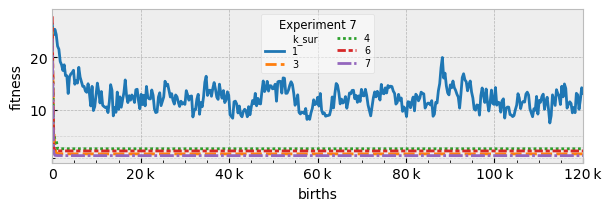

Wall time: 1.21 s


In [70]:
%%time
for exp_n in range(6, 7):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(6, 2))
    if exp_n in [4]:
        palette = sns.color_palette("tab10", 6)
    else:
        palette = sns.color_palette("tab10", 5)
    query = fit_plot["exp"] == (exp_n + 1)
    data_exp = fit_plot[query]
    sns.lineplot(
        x="births",
        y="best",
        style=factors[exp_n],
        hue=factors[exp_n],
        palette=palette,
        data=data_exp,
        ci=None,
        ax=ax,
        estimator=np.mean,
    )
    ax.set_axisbelow(True)
    ax.legend(
        labelspacing=0.25,
        fontsize="x-small",
        ncol=2,
        title="Experiment " + str(exp_n + 1),
        title_fontsize="small",
        facecolor="white",
        framealpha=0.5,
        loc=9,
    )
    ax.xaxis.set_major_formatter(formatter1)
    ax.set_xlim((0, 120e3))
    ax.set_xlabel("births", fontsize="medium")
    ax.set_ylabel("fitness", fontsize="medium")
    ax.minorticks_on()
    ax.set_yticks([1, 3, 5], minor=True)
    ax.grid(True, axis="y", which="minor", alpha=0.5)

    plt.show()

### Agregated per experiment

Development of average minimum (best) fitness for each experiment (Each experiment has one factor at different levels)

C:\Anaconda3\envs\ea_thesis\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


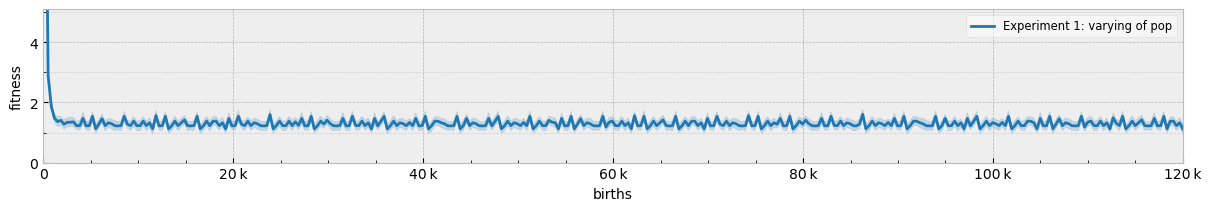

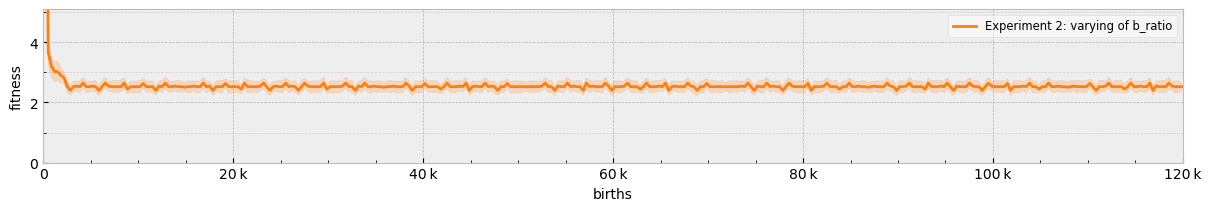

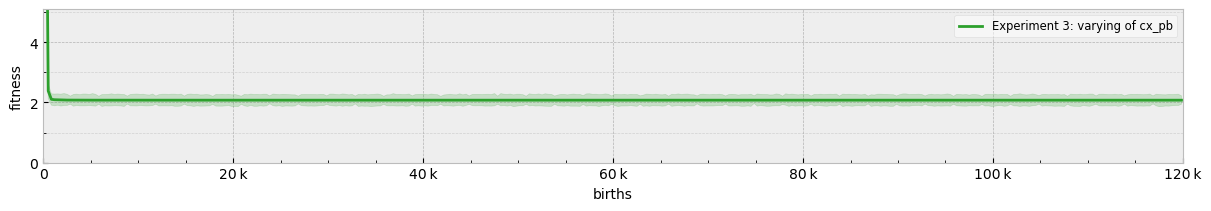

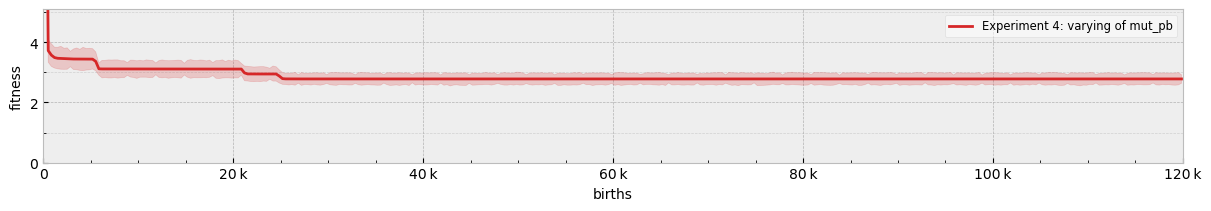

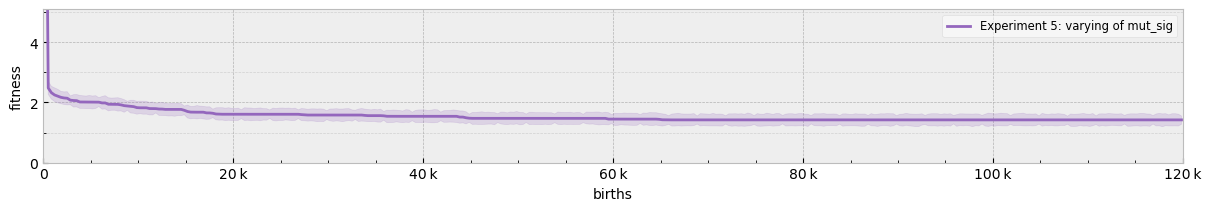

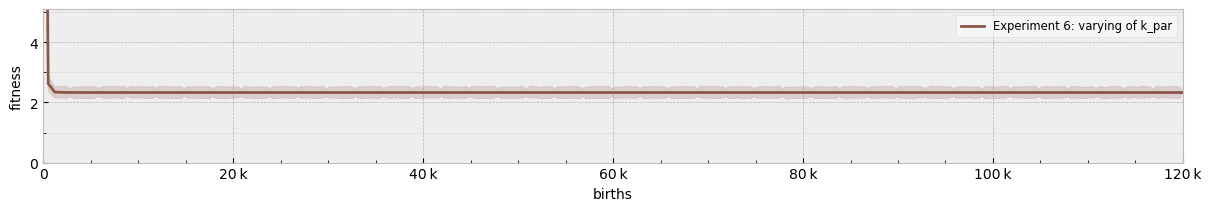

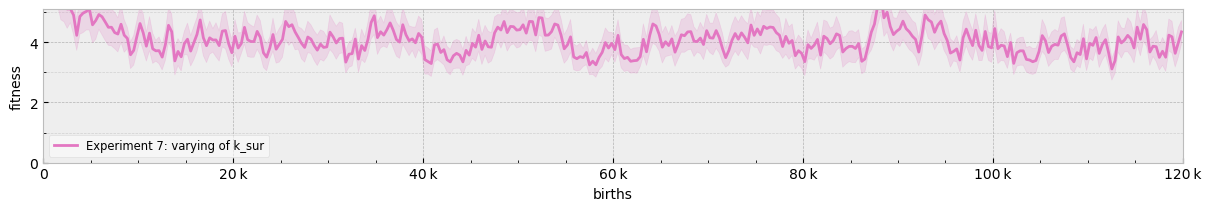

Wall time: 1min 39s


In [22]:
%%time
palette = it.cycle(sns.color_palette("tab10"))
for exp_n in range(7):
    fig, ax = plt.subplots(constrained_layout=True, figsize=(12, 2))
    c = next(palette)
    query = fit_plot["exp"] == (exp_n + 1)
    data_exp = fit_plot[query]
    bin_min = data_exp["births"].min()
    bin_max = data_exp["births"].max()
    bins = np.linspace(bin_min, bin_max, 361)
    plot_centers = (bins[:-1] + bins[1:]) / 2
    plot_centers = plot_centers.astype(int)
    data_exp["range"] = pd.cut(
        data_exp.births, bins, labels=plot_centers, include_lowest=True
    )
    sns.lineplot(
        x="range",
        y="best",
        label=("Experiment " + str(exp_n + 1) + ": varying of " + factors[exp_n]),
        color=c,
        data=data_exp,
        ci=68,
        ax=ax,
    )
    ax.set_axisbelow(True)
    ax.legend(facecolor="white", fontsize="small", framealpha=0.5)
    ax.xaxis.set_major_formatter(formatter1)
    ax.set_xlim((0, 120e3))
    ax.set_xlabel("births", fontsize="medium")
    ax.set_ylim((0, 5.1))
    ax.set_ylabel("fitness", fontsize="medium")
    ax.minorticks_on()
    ax.set_yticks([1, 3, 5], minor=True)
    ax.grid(True, axis="y", which="minor", alpha=0.5)

    plt.show()